# Step 1: Collect Packets Data

- Follow build instruction in [PacketSorter repository](https://github.com/rickyzhang82/PacketSorter).
- Run **PacketSorter** application in your home router for a month.
- Deploy V2Ray server in AWS Lightsail.
- Deploy V2Ray client through vmess protcol at home.
- Use V2Ray client to generate V2Ray traffic at home.

# Step 2: Offline Data Cleaning

- Follow build instruction in [PcapProcessor repository](https://github.com/rickyzhang82/PcapProcessor).
- Retain pcap files which are not in missing caputing log from **PacketSorter**.
- Retain pcap files which contains extactly **16** packets.
- Drop the link layer header in each packet, i.e. the Ethernet frame header.
- Mask source's and destination's IP address and port with zero value. Recompute the checksum in TCP and IP header cheksum.
- Truncate or pad zero to each packet to **1500** bytes.

# Step 3: Load Modified Packets

## Data Exploration

In [1]:
import numpy as np
import pandas as pd
import os.path

In [2]:
# Packet data type
FIXED_PACKET_SIZE = 1500
NUM_OF_PACKETS = 16

# v2ray server IP
V2RAY_HOST_IP = # Fill in your V2Ray server IP
# v2ray server port
V2RAY_PORT = # Fill in your V2Ray server port
# v2ray traffic tag
V2RAY_HOST_TAG = '%s.%s' % (V2RAY_HOST_IP, V2RAY_PORT)

# Load constant
DATA_ROOT = '/src/data/tcpsorter/mod-tcpsorter'

In [3]:
MOD_FILE_BASE = '192.168.3.37.65516-45.57.24.141.443.bin'
MOD_FILE_PATH = os.path.join(DATA_ROOT, '26DEC2019', MOD_FILE_BASE)

packet_dt = np.dtype((np.uint8, FIXED_PACKET_SIZE))
df = pd.DataFrame(np.fromfile(MOD_FILE_PATH, dtype=packet_dt, count=NUM_OF_PACKETS))
print(df.shape)
print(df)

(16, 1500)
    0     1     2     3     4     5     6     7     8     9     ...  1490  \
0     69     0     2    57     0     0    64     0    64     6  ...     0   
1     69     0     5   220     0     0    64     0    56     6  ...   104   
2     69     0     5   220     0     1    64     0    56     6  ...   228   
3     69     0     1   135     0     2    64     0    56     6  ...     0   
4     69     0     0   145     0     0    64     0    64     6  ...     0   
5     69     0     0    58     0     0    64     0    56     6  ...     0   
6     69     0     0    97     0     0    64     0    56     6  ...     0   
7     69     0     2   102     0     0    64     0    64     6  ...     0   
8     69     0     2   122     0     0    64     0    56     6  ...     0   
9     69     0     5   220     0     0    64     0    56     6  ...   118   
10    69     0     2   188     0     1    64     0    56     6  ...     0   
11    69     0     2   111     0     0    64     0    64     6  .

## Create Data Generator

In [4]:
import numpy as np
import math
import os.path
from pathlib import Path
import glob
from tensorflow.keras.utils import Sequence

FIXED_PACKET_SIZE = 1500
NUM_OF_PACKETS_PER_FILE = 16
RESCALE_FACTOR = 1./255

# v2ray traffic tag
TRAINING_DATA_PERCENTAGE = 0.8
PACKET_FILE_EXT = '*.bin'


def rglob(data_root, file_ext):
    files = list()
    for filePath in Path(data_root).rglob(file_ext):
        files.append(str(filePath))
    return files


def binary_classification(packet_path, match_string=V2RAY_HOST_TAG):
    """Binary network traffic classification function

    :param packet_path: file path to packet
    :param match_string:
    :return: 1, if it is v2ray traffice. 0, otherwise.
    """
    if packet_path.find(match_string) != -1:
        return 1
    else:
        return 0


def generate_train_validation_packet_path_list(data_root, training_pct=TRAINING_DATA_PERCENTAGE, eqaul_size=True):
    file_list = rglob(data_root, PACKET_FILE_EXT)
    v2ray_file_list = [file_path for file_path in file_list if binary_classification(file_path) == 1]
    non_v2ray_file_list = [file_path for file_path in file_list if binary_classification(file_path) == 0]

    if eqaul_size:
        cut_off_count = min(len(v2ray_file_list), len(non_v2ray_file_list))
        v2ray_file_size = cut_off_count
        non_v2ray_file_size = cut_off_count
    else:
        v2ray_file_size = len(v2ray_file_list)
        non_v2ray_file_size = len(non_v2ray_file_list)

    v2ray_indexes = np.arange(len(v2ray_file_list))
    np.random.shuffle(v2ray_indexes)
    non_v2ray_indexes = np.arange(len(non_v2ray_file_list))
    np.random.shuffle(non_v2ray_indexes)

    training_file_list = [v2ray_file_list[index]
                          for index in v2ray_indexes[:math.ceil(v2ray_file_size * training_pct)]] + \
                         [non_v2ray_file_list[index]
                          for index in non_v2ray_indexes[:math.ceil(non_v2ray_file_size * training_pct)]]

    validation_file_list = [v2ray_file_list[index]
                            for index in v2ray_indexes[math.ceil(v2ray_file_size * training_pct): v2ray_file_size]] + \
                           [non_v2ray_file_list[index]
                            for index in non_v2ray_indexes[math.ceil(non_v2ray_file_size * training_pct): non_v2ray_file_size]]

    print("Statistics: ")
    print("Total V2ray traffic %d, Total non-V2ray traffic %d" % (len(v2ray_file_list), len(non_v2ray_file_list)))
    print("Output train traffic %d, Total validation traffic %d" % (len(training_file_list), len(validation_file_list)))

    return training_file_list, validation_file_list


class PacketDataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, data_path_list, classification_func=binary_classification, rescale=RESCALE_FACTOR,
                 batch_size=32, dim=(NUM_OF_PACKETS_PER_FILE, FIXED_PACKET_SIZE), shuffle=True, predict=False):
        """Initialization

        :param data_path_list: list of data path
        :param classification_func: binary classification function
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating data dimension
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.data_path_list = data_path_list
        self.classification_func = classification_func
        self.rescale = rescale
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.predict = predict
        self.indexes = np.arange(len(self.data_path_list))
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number samples of batches per epoch

        :return: number of batches per epoch
        """
        return int(np.floor(len(self.data_path_list) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data

        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate sub packet path list
        data_path_sub_list = [self.data_path_list[k] for k in indexes]

        # Generate data
        x = self.standardize(self._generate_x(data_path_sub_list))
        if self.predict:
            return x
        else:
            y = self._generate_y(data_path_sub_list)
            return x, y

    def standardize(self, x):
        if self.rescale:
            x *= self.rescale
        return x

    def on_epoch_end(self):
        """Updates indexes after each epoch

        """
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _generate_x(self, file_path_list):
        """Generates data containing batch_size data

        :param file_path_list: file path list
        :return: batch of data
        """
        # Initialization
        x = np.empty((self.batch_size, *self.dim))

        # Generate data
        for i, file_path in enumerate(file_path_list):
            # Store sample
            x[i, ] = self._load_packet(file_path)

        return x

    def _generate_y(self, file_path_list):
        """Generates data containing batch_size

        :param file_path_list: file path list
        :return: batch if masks
        """
        y = np.empty((self.batch_size, ), dtype=int)

        # Generate data
        for i, file_path in enumerate(file_path_list):
            y[i,] = self.classification_func(file_path)

        return y

    def _load_packet(self, packet_path):
        """Load packet

        :param packet_path: path to packet
        :return: packet in numpy array
        """
        packet_dt = np.dtype((np.uint8, FIXED_PACKET_SIZE))
        packet_data = np.fromfile(packet_path, dtype=packet_dt, count=NUM_OF_PACKETS_PER_FILE)
        return packet_data.astype(np.float32)


In [5]:
# Generate training data and validation file list
train_file_list, val_file_list = generate_train_validation_packet_path_list(data_root=DATA_ROOT, eqaul_size=True)

Statistics: 
Total V2ray traffic 5070, Total non-V2ray traffic 190531
Output train traffic 8112, Total validation traffic 2028


In [6]:
# Create train data generator and validation data generator
train_data_generator = PacketDataGenerator(train_file_list)
val_data_generator = PacketDataGenerator(val_file_list)

In [7]:
len(train_data_generator)

253

In [8]:
x, y = train_data_generator.__getitem__(0)
# 32 samples in each batch, 16 packets in each connection, 1500 byte in each packet
print(np.shape(x))
print(x)
print(np.shape(y))
print(y)

(32, 16, 1500)
[[[ 0.27058824  0.          0.00784314 ...,  0.          0.          0.        ]
  [ 0.27058824  0.          0.00392157 ...,  0.          0.          0.        ]
  [ 0.27058824  0.          0.         ...,  0.          0.          0.        ]
  ..., 
  [ 0.27058824  0.          0.         ...,  0.          0.          0.        ]
  [ 0.27058824  0.          0.         ...,  0.          0.          0.        ]
  [ 0.27058824  0.          0.00392157 ...,  0.          0.          0.        ]]

 [[ 0.27058824  0.          0.00392157 ...,  0.          0.          0.        ]
  [ 0.27058824  0.          0.01960784 ...,  0.31764706  0.19607843
    0.9254902 ]
  [ 0.27058824  0.          0.00784314 ...,  0.          0.          0.        ]
  ..., 
  [ 0.27058824  0.          0.01960784 ...,  0.70196078  0.89803922
    0.03921569]
  [ 0.27058824  0.          0.01960784 ...,  0.85490196  0.80784314
    0.31764706]
  [ 0.27058824  0.          0.01960784 ...,  0.89803922  0.8745098


# Step 4: Classification

## Model Construction

In [9]:
from keras import layers
from keras import models

model = models.Sequential()

# Convnet
model.add(layers.Conv1D(200, 5, activation='relu',
                        input_shape=(16, 1500), data_format="channels_last"))
model.add(layers.Conv1D(100, 4, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.25))

# Fully connected network
model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Dropout(0.05))
model.add(layers.Dense(128))
model.add(layers.Dropout(0.05))
model.add(layers.Dense(32))
model.add(layers.Dropout(0.05))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 12, 200)           1500200   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 9, 100)            80100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 100)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 100)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               102656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

In [10]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

In [11]:
from keras.callbacks import EarlyStopping
# Create train data generator and validation data generator
train_generator = PacketDataGenerator(train_file_list)
validation_generator = PacketDataGenerator(val_file_list)

#es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1)

history = model.fit_generator(
      train_generator,
      epochs=10,
      #callbacks=[es],
      validation_data=validation_generator,
      workers=3,
      use_multiprocessing=True)

Epoch 1/10
253/253 [==============================] - 111s 440ms/step - loss: 0.1287 - acc: 0.9502 - val_loss: 0.0139 - val_acc: 0.9970
Epoch 2/10
253/253 [==============================] - 2s 9ms/step - loss: 0.0244 - acc: 0.9909 - val_loss: 0.0055 - val_acc: 0.9975
Epoch 3/10
253/253 [==============================] - 2s 9ms/step - loss: 0.0142 - acc: 0.9951 - val_loss: 0.0051 - val_acc: 0.9980
Epoch 4/10
253/253 [==============================] - 2s 8ms/step - loss: 0.0087 - acc: 0.9973 - val_loss: 0.0068 - val_acc: 0.9975
Epoch 5/10
253/253 [==============================] - 2s 9ms/step - loss: 0.0070 - acc: 0.9979 - val_loss: 0.0134 - val_acc: 0.9960
Epoch 6/10
253/253 [==============================] - 2s 9ms/step - loss: 0.0065 - acc: 0.9984 - val_loss: 0.0020 - val_acc: 0.9990
Epoch 7/10
253/253 [==============================] - 2s 8ms/step - loss: 0.0025 - acc: 0.9989 - val_loss: 0.0068 - val_acc: 0.9970
Epoch 8/10
253/253 [==============================] - 2s 8ms/step - loss

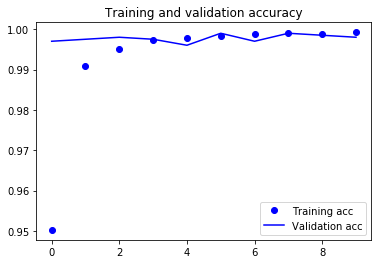

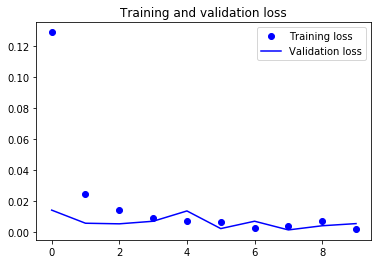

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Ricky comments:

- We have equal size of V2Ray traffic and non-V2Ray traffic. Both have **5070** samples.
- We set aside 20% of data for validation. Both training data and validation data have the same 1:1 ratio of V2Ray traffic and non-V2Ray traffic.
- The training accuracy rate can reach 99% after 1st epoch. So is validation accuracy is above 99%.

## Early Stopping

- To keep the best model, we apply early stopping techinque.

In [13]:
from keras.callbacks import EarlyStopping
# Create train data generator and validation data generator
train_generator = PacketDataGenerator(train_file_list)
validation_generator = PacketDataGenerator(val_file_list)

es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1)

history = model.fit_generator(
      train_generator,
      callbacks=[es],
      validation_data=validation_generator,
      workers=3,
      use_multiprocessing=True)

Epoch 1/1
253/253 [==============================] - 2s 9ms/step - loss: 0.0016 - acc: 0.9994 - val_loss: 0.0028 - val_acc: 0.9985


In [14]:
# Save this model for later use
from keras.models import load_model
model.save('/src/data/tcpsorter/model/v2ray_classifier_equal_sample.h5')

## Evaluate Model

In [15]:
def evaulate(file_list):
    # predict y
    predict_generator = PacketDataGenerator(file_list, predict=True, shuffle=False)
    y_predict = model.predict_generator(predict_generator, workers=3, use_multiprocessing=True, verbose=1)
    y_predict = y_predict.ravel()
    # get real y
    data_generator = PacketDataGenerator(file_list, predict=False, shuffle=False)
    y_stat = None
    x = 1
    for _, y in data_generator:
        if x > len(data_generator):
            break
        if y_stat is None:
            y_stat = y
        else:
            y_stat = np.concatenate((y_stat, y), axis=0)
        x+=1
    return y_predict, y_stat

from sklearn.metrics import roc_curve

y_predict, y_stat = evaulate(val_file_list)
print('shape of predict: %s, shape of real: %s' % (y_predict.shape, y_stat.shape))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_stat, y_predict)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

63/63 [==============================] - 0s 7ms/step
shape of predict: (2016,), shape of real: (2016,)


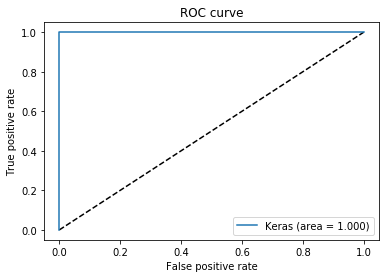

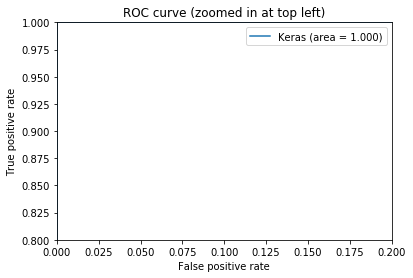

In [16]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

### Ricky comments:

- Perfect ROC curve.

# Step 5: More Evaluation with unseen V2Ray traffic

- Change vmess protocol's UUID in both server side and client side.
- Use previously trained model to classfiy

## Load Model

In [17]:
from keras.models import load_model

model = load_model('/src/data/tcpsorter/model/v2ray_classifier_equal_sample.h5')

## unseen vmess Data

In [18]:
# Load constant
DATA_ROOT = '/src/data/tcpsorter/mod-tcpsorter.uuid.fb46221f-8f70-4f06-8b23-e2b61253c054'

In [19]:
eval_file_list, _ = generate_train_validation_packet_path_list(data_root=DATA_ROOT, 
                                                               training_pct=1, eqaul_size=False)

Statistics: 
Total V2ray traffic 976, Total non-V2ray traffic 1522
Output train traffic 2498, Total validation traffic 0


In [20]:
# Create evaluation generator
eval_generator = PacketDataGenerator(eval_file_list, shuffle=False)

eval_result = model.evaluate_generator(eval_generator,workers=3, use_multiprocessing=True, verbose=1)

78/78 [==============================] - 7s 84ms/step


In [21]:
print(eval_result)

[0.013206126600994668, 0.99879807692307687]


78/78 [==============================] - 1s 7ms/step
shape of predict: (2496,), shape of real: (2496,)


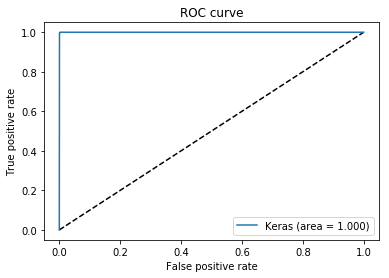

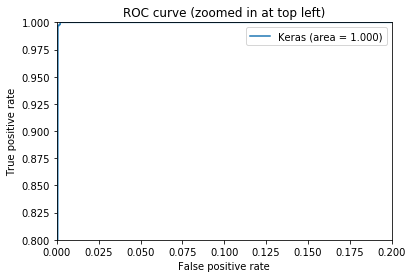

In [22]:
from sklearn.metrics import roc_curve

y_predict, y_stat = evaulate(eval_file_list)
print('shape of predict: %s, shape of real: %s' % (y_predict.shape, y_stat.shape))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_stat, y_predict)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

### Ricky comments:

- Even UUID of vmess protocol has been changed, the previously trained model can still reach **0.99879** accuracy!
- Another perfect ROC curve.

# Conclusion

- Yes, [The patent claim](https://files.catbox.moe/vmzj04.pdf) is valid. 
- People who use V2Ray are fucked. Big borther knows you are using V2Ray without knowing V2Ray server IP or port. They can block it at any time at will
- A new question arises: how can we bypass it?